First implementation of a trajectory transformer, where each observation is a vector of [lat lon, sog, cog]

In [1]:

from collections import defaultdict
from typing import Iterator, List
from copy import deepcopy

import numpy as np 
import torch
import torch.nn as nn
import torch.functional as f
import torch.nn.functional as F
import pickle 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
from tqdm.notebook import tqdm as tnb
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
device = torch.device('cuda:0')

In [2]:
# Parameters (could move to config file if wanna be fancy)

train_path = './Data/BetterTimeData/marineTrainS.pkl'
val_path = './Data/BetterTimeData/marineValS.pkl'

d_model = 128 # Size of the embedding space
max_seq_len = 144 # Maximum number of observations per trajectory
min_seq_len = 24
input_dim = 4 # [lat, lon, sog, cog]
output_dim = input_dim # [lat, lon, sog, cog]
n_enc_layers = 6 
n_dec_layers = n_enc_layers
n_heads = 8 # number of attentionheads in the encoder and decoder
d_ff = 512 # Dimension of the ff nn at the end of a block

batch_by_size = True
batch_size = 64
time_encoding = True

params = [input_dim, d_model, n_heads, n_enc_layers, n_dec_layers, d_ff, max_seq_len, output_dim, time_encoding, batch_size]

In [3]:
class PositionalEncoding(nn.Module):
    """
    Postional encoder using the sinusiodals from the original paper
    """
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()*(-torch.log(torch.tensor(10000.0))/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0)
        self.pe = pe.to(device)

    def forward(self, x):
        #print(x.size()) # 64, 40, 128 = bs, Time , d_model
        x = x + self.pe[:x.size(0), :x.size(1), :]
        return x

class TimeEncoding(torch.nn.Module):
 
    def __init__(self, d_model, max_seq_len, batch_size, norm_time_factor = 350000, normalized_time = True):
        super(TimeEncoding, self).__init__()
        self.d_model = d_model
        self.norm_time_factor = norm_time_factor
        self.max_seq_len= max_seq_len
        self.batch_size = batch_size
        indices = torch.arange(0, d_model, 2)
        indices_rep = indices.repeat_interleave(2)
        values = 1 / (10000 ** (2*indices_rep/d_model))
        block_matrix = torch.ones((batch_size, max_seq_len, d_model))
        self.basic_block = (block_matrix*values).to(device)
        self.normalized_time = normalized_time
 
 
    def forward(self, x_data, x_time):
        batch_size_curr, seq_time_current, d_model_current = x_data.size()
 
        if not self.normalized_time:
            # Normalize time to [0, 1]
            x_time = x_time / self.max_time  
 
 
        # Slice to fit shroter batches mayhaps
        te = x_time.unsqueeze(2) * self.basic_block[:batch_size_curr,:seq_time_current,:]
 
        # Trigger funcs for the different datapoints
        te[:, :, 0::2] = torch.sin(te[:, :, 0::2])
        te[:, :, 1::2] = torch.cos(te[:, :, 1::2])
 
        # Add positional encoding to the input data
        new_x = x_data + te
 
        return new_x



In [4]:
class TrajectoryEncoder(nn.Module):
    """
    Basic Encoder relying mainly on pytorchs modules 
    """
    def __init__(self, input_dim, d_model, n_heads, n_enc_layers, d_ff, max_len, time_encoding, batch_size):
        super(TrajectoryEncoder, self).__init__()
        self.emb_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.time_enc = TimeEncoding(d_model, max_len, batch_size)
        self.time_encoding = time_encoding
        self.batch_size = batch_size

        enc_layers = nn.TransformerEncoderLayer(d_model, n_heads, d_ff, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(enc_layers, n_enc_layers)

    def forward(self, src):
        if self.time_encoding:
            src_features = src[:,:,:-1]
            src_timestamps = src[:,:,-1]
            x = self.emb_proj(src_features)
            x = self.time_enc(x, src_timestamps)
        else:
            x = self.emb_proj(src) # Take our input from input_dim to embedding-d
            x = self.pos_enc(x)
        x = self.transformer_encoder(x)
        return x

class TrajectoryDecoder(nn.Module):

    def __init__(self, input_dim, d_model, n_heads, n_dec_layers, d_ff, max_len, 
                 output_dim, time_encoding, batch_size):
        super(TrajectoryDecoder, self).__init__()
        self.emb_proj = nn.Linear(input_dim, d_model)
        self.emb_proj_time = nn.Linear(input_dim-1, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.time_encoding = time_encoding
        self.time_enc = TimeEncoding(d_model, max_len, batch_size)
        self.batch_size = batch_size

        dec_layers = nn.TransformerDecoderLayer(d_model, n_heads, d_ff, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(dec_layers, n_dec_layers)
        self.output_proj = nn.Linear(d_model, output_dim)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        """
        tgt (Tensor) = the sequence to the decoder (required).

        memory (Tensor) = the sequence from the last layer of the encoder. Size bs, T, n_emb
        """
        

        if self.time_encoding:
            tgt_features = tgt[:,:,:-1]
            tgt_timestamps = tgt[:,:,-1]
            target = self.emb_proj(tgt_features)
            target = self.time_enc(target, tgt_timestamps)

        else:
            tgt = self.emb_proj(tgt)
            target = self.pos_enc(tgt)

        decoded = self.transformer_decoder(target, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        output = self.output_proj(decoded) # project down to output_dim
        return output

class TrajectoryAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, n_enc_layers, n_dec_layers, d_ff, max_len, output_dim, time_encoding, batch_size):
        super(TrajectoryAutoencoder, self).__init__()
        self.encoder = TrajectoryEncoder(input_dim, d_model, n_heads, n_enc_layers, d_ff, max_len, time_encoding, batch_size)
        self.decoder = TrajectoryDecoder(input_dim, d_model, n_heads, n_dec_layers, d_ff, max_len, output_dim, time_encoding, batch_size)

    def forward(self, tgt):
        memory = self.encoder(tgt)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1))
        reconstructed = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        return reconstructed

In [5]:
class MarineDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]).to(device)

class MarineDatasetPadding(Dataset):
    def __init__(self, data_dictionary, min_seq_len, max_seq_len, input_dim, time_encoding):
        
        self.min_seq_len = min_seq_len
        self.max_seq_len = max_seq_len
        self.input_dim = input_dim

        


        self.dict = data_dictionary
        self.keys = list(data_dictionary.keys())

        for key in self.keys:
            if len(self.dict[key]['traj']) < min_seq_len:
                del self.dict[key]
                self.keys.remove(key)


    def __len__(self):
        return len(self.dict)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        traj_data = self.dict[key]['traj']
        
        # Cut off the mmsi and timestamp and return trajectory
        if len(traj_data) >= self.max_seq_len:
            return torch.tensor(traj_data[:self.max_seq_len,:self.input_dim]).to(device)
        else: 
            needed_padding = self.max_seq_len - len(traj_data)
            res = F.pad(torch.tensor(traj_data[:,:self.input_dim]), (0,0, 0, needed_padding), "constant", 0.0)
        
            return res.to(device)

class BatchBySizeSampler(Sampler[List[int]]):
    def __init__(self, data, batch_size, randomize=True):
        self.batch_size = batch_size
        self.randomize = randomize
        self.paths_by_length = defaultdict(list)
        for i in range(len(data)):
            self.paths_by_length[len(data[i])].append(i)
        self.num_batches = sum((len(xs) + batch_size - 1) // batch_size for xs in self.paths_by_length.values())

    def __len__(self):
        return self.num_batches

    def __iter__(self) -> Iterator[List[int]]:
        if self.randomize:
            for xs in self.paths_by_length.values():
                np.random.shuffle(xs)
        chunks = [xs[i : i + self.batch_size] for xs in self.paths_by_length.values() for i in range(0, len(xs), self.batch_size)]
        np.random.shuffle(chunks)
        yield from chunks


n_dims_to_load = input_dim
if time_encoding:
    n_dims_to_load += 1

with open(train_path, 'rb') as f:
    train_data = pickle.load(f)
    train_data = [x["traj"][:max_seq_len,:n_dims_to_load] for x in train_data.values() if len(x["traj"]) >= min_seq_len]
with open(val_path, 'rb') as f:
    val_data = pickle.load(f)
    val_data = [x["traj"][:max_seq_len,:n_dims_to_load] for x in val_data.values() if len(x["traj"]) >= min_seq_len]
train_dataloader_bbs = DataLoader(MarineDataset(train_data), batch_sampler=BatchBySizeSampler(train_data, batch_size))
validation_dataloader_bbs = DataLoader(MarineDataset(val_data), batch_sampler=BatchBySizeSampler(val_data, batch_size))

with open(train_path, 'rb') as f:
    train_data = pickle.load(f)
with open(val_path, 'rb') as f:
    val_data = pickle.load(f)
train_dataloader_no_bbs = DataLoader(MarineDatasetPadding(train_data, min_seq_len=min_seq_len, max_seq_len=max_seq_len, input_dim=n_dims_to_load, time_encoding=time_encoding), batch_size=batch_size, shuffle=True)
validation_dataloader_no_bbs = DataLoader(MarineDatasetPadding(val_data, min_seq_len=min_seq_len, max_seq_len=max_seq_len, input_dim=n_dims_to_load, time_encoding=time_encoding), batch_size=batch_size, shuffle=True)

In [6]:
# Lat min 53.4 max 66.2
# lon min 9.4 max 30.5
# Max speed 50
# Max heading 360

def train_loop(model, dataloader, criterion, optimizer, time_encoding ):
    train_data_size = len(dataloader.dataset)
    model.train()
    cum_loss = 0.0
    count_trained_on = 0
    slice_end = int(time_encoding)
    for batch, X in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, X[:,:,:-slice_end])
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()

        count_trained_on += len(X)
        if batch % 50 == 0:
            print(f' loss {loss.item():>4f} [{count_trained_on:>5d} / {train_data_size:>5d} ]', flush=True)
    return cum_loss

def test_loop(model, dataloader, criterion, time_encoding):
    model.eval()
    cum_loss = 0.0
    slice_end = int(time_encoding)
    loss = []
    with torch.no_grad():
        for X in dataloader:
            pred = model(X)
            current_loss = criterion(X[:,:,:-slice_end], pred).item()
            cum_loss += current_loss

            loss.append(current_loss)

    print(f'Test set: \nCumulative loss: {cum_loss}, Average Loss {np.mean(loss):>8f}')
    return cum_loss

In [7]:
model = TrajectoryAutoencoder(*params)
model = model.to(device)
criterion = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

warmup = 20

# Linear increase to 1e-4 until warmup finished, then exp decay for remainder of time
L1 = lambda epoch: (epoch+1) / (warmup + 1) if epoch < warmup else torch.e**((warmup - epoch)/10)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, L1)


n_epochs = 100

training_loss = torch.zeros(n_epochs)
val_loss = torch.zeros(n_epochs)

min_val_loss = 10000
patience = 10
val_counter = 0

best_state_dict = None

for epoch in range(n_epochs):
    print(f'Fuck you; It\'s epoch #{epoch + 1}')
    current_training_loss = train_loop(model, dataloader=train_dataloader_bbs, criterion=criterion, optimizer=optimizer, time_encoding = time_encoding)
    current_val_loss = test_loop(model, dataloader=validation_dataloader_bbs, criterion=criterion, time_encoding = time_encoding)

    training_loss[epoch] = current_training_loss
    val_loss[epoch]  = current_val_loss

    scheduler.step()

    if epoch > warmup:
        if current_val_loss > min_val_loss:
            val_counter += 1
            if val_counter == patience: 
                print(f'Patience limit reached at epoch {epoch}')
                break

        else:
            val_counter = 0
            min_val_loss = current_val_loss
            best_state_dict = deepcopy(model.state_dict())



save_after_training = True
savename = 'time_as_pe_working'
if save_after_training:
    loss_dict = {
        'training_loss': training_loss, 
        'val_loss': val_loss
        }
    torch.save(best_state_dict, f'./traj_trans_2307_{savename}.pt')
    torch.save(loss_dict, f'./loss_history_2307_{savename}.pt')



Fuck you; It's epoch #1


c:\Users\Administrator\anaconda3\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


 loss 0.677345 [   10 / 11609 ]
 loss 0.061812 [ 2409 / 11609 ]
 loss 0.058329 [ 4932 / 11609 ]
 loss 0.042827 [ 7598 / 11609 ]
 loss 0.039353 [ 9882 / 11609 ]
Test set: 
Cumulative loss: 4.247744535945095, Average Loss 0.018153
Fuck you; It's epoch #2
 loss 0.026779 [   64 / 11609 ]
 loss 0.023811 [ 2630 / 11609 ]
 loss 0.028393 [ 5057 / 11609 ]
 loss 0.024527 [ 7603 / 11609 ]
 loss 0.023845 [ 9833 / 11609 ]
Test set: 
Cumulative loss: 2.2549629553448094, Average Loss 0.009637
Fuck you; It's epoch #3
 loss 0.017270 [    9 / 11609 ]
 loss 0.018903 [ 2466 / 11609 ]
 loss 0.017237 [ 5003 / 11609 ]
 loss 0.015633 [ 7547 / 11609 ]
 loss 0.013261 [10137 / 11609 ]
Test set: 
Cumulative loss: 0.7101242897198918, Average Loss 0.003035
Fuck you; It's epoch #4
 loss 0.012530 [   56 / 11609 ]
 loss 0.011013 [ 2463 / 11609 ]
 loss 0.010051 [ 5043 / 11609 ]
 loss 0.009214 [ 7514 / 11609 ]
 loss 0.008721 [ 9904 / 11609 ]
Test set: 
Cumulative loss: 0.46645472968352203, Average Loss 0.001993
Fuck you

In [8]:
model = TrajectoryAutoencoder(*params)
model = model.to(device)
criterion = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

warmup = 20

# Linear increase to 1e-4 until warmup finished, then exp decay for remainder of time
L1 = lambda epoch: (epoch+1) / (warmup + 1) if epoch < warmup else torch.e**((warmup - epoch)/10)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, L1)


n_epochs = 100



training_loss = torch.zeros(n_epochs)
val_loss = torch.zeros(n_epochs)

min_val_loss = 10000
patience = 5
val_counter = 0


for epoch in range(n_epochs):
    print(f'Fuck you; It\'s epoch #{epoch + 1}')
    current_training_loss = train_loop(model, dataloader=train_dataloader_no_bbs, criterion=criterion, optimizer=optimizer, time_encoding = time_encoding)
    current_val_loss = test_loop(model, dataloader=validation_dataloader_no_bbs, criterion=criterion, time_encoding = time_encoding)

    training_loss[epoch] = current_training_loss
    val_loss[epoch]  = current_val_loss

    scheduler.step()

    if current_val_loss > min_val_loss:
        val_counter += 1
        if val_counter == patience: 
            break
    else:
        val_counter = 0
        min_val_loss = current_val_loss



save_after_training = True
savename = 'no_bbs_time_as_pe_working'
if save_after_training:
    loss_dict = {
        'training_loss': training_loss, 
        'val_loss': val_loss
        }
    save_string = 'fail_and_error'
    torch.save(model.state_dict(), f'./traj_trans_2307_{savename}.pt')
    torch.save(loss_dict, f'./loss_history_2307_{savename}.pt')



Fuck you; It's epoch #1
 loss 0.393122 [   64 / 11609 ]
 loss 0.063218 [ 3264 / 11609 ]
 loss 0.056496 [ 6464 / 11609 ]
 loss 0.054993 [ 9664 / 11609 ]
Test set: 
Cumulative loss: 6.398228463933513, Average Loss 0.035155
Fuck you; It's epoch #2
 loss 0.048277 [   64 / 11609 ]
 loss 0.046407 [ 3264 / 11609 ]
 loss 0.037435 [ 6464 / 11609 ]
 loss 0.031226 [ 9664 / 11609 ]
Test set: 
Cumulative loss: 2.585740155773067, Average Loss 0.014207
Fuck you; It's epoch #3
 loss 0.025956 [   64 / 11609 ]
 loss 0.018369 [ 3264 / 11609 ]
 loss 0.015124 [ 6464 / 11609 ]
 loss 0.012803 [ 9664 / 11609 ]
Test set: 
Cumulative loss: 0.48456714798473743, Average Loss 0.002662
Fuck you; It's epoch #4
 loss 0.012093 [   64 / 11609 ]
 loss 0.010013 [ 3264 / 11609 ]
 loss 0.008822 [ 6464 / 11609 ]
 loss 0.007475 [ 9664 / 11609 ]
Test set: 
Cumulative loss: 0.2677907751172693, Average Loss 0.001471
Fuck you; It's epoch #5
 loss 0.007466 [   64 / 11609 ]
 loss 0.006927 [ 3264 / 11609 ]
 loss 0.006157 [ 6464 / 1

In [ ]:
def plot_some_paths( model, val_loader, t_max, criterion ):
    model.eval()

    rand_sample = next(iter(val_loader))[0]
    rand_sample = rand_sample.unsqueeze(0)
    with torch.no_grad():
        recon_sample = model(rand_sample)

    recon_sample = recon_sample.squeeze()
    rand_sample = rand_sample.squeeze()
    
    meas_x, meas_y = [], []
    model_x, model_y = [], []

    for i in range(len(rand_sample)):
        meas_x.append(rand_sample[i,0].item())
        meas_y.append(rand_sample[i,1].item())
        model_x.append(recon_sample[i,0].item())
        model_y.append(recon_sample[i,1].item())


    mse_error = criterion(rand_sample, recon_sample)

    plt.plot(meas_x, meas_y, 'b', label = "True traj")
    plt.plot(model_x, model_y, 'k', label = "Est path")
    plt.title(f"MSE = {mse_error:.6f}")
    plt.legend()

    plt.show()

new_model = TrajectoryAutoencoder(*params)
new_model.load_state_dict(torch.load("./traj_trans_1807_bbs_og.pt"))

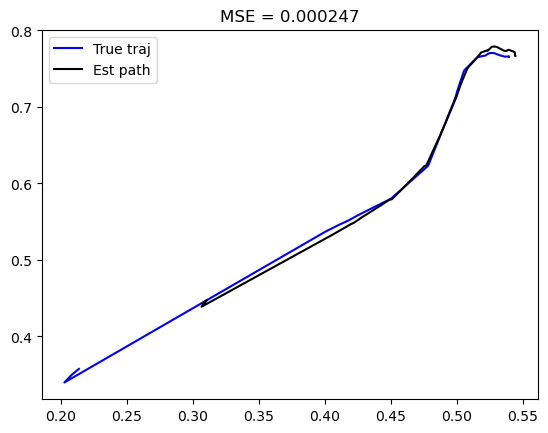

In [ ]:
plot_some_paths(model, validation_dataloader, max_seq_time, criterion)

In [ ]:
model4 = TrajectoryAutoencoder(*params)
model4.load_state_dict(torch.load('./traj_trans_2207_test.pt'))

<All keys matched successfully>

In [ ]:
model2 = TrajectoryAutoencoder(*params)
model2.load_state_dict(torch.load('./traj_trans_2307_time_as_pe_working.pt'))
model3 = TrajectoryAutoencoder(*params)
model3.load_state_dict(torch.load('./traj_trans_2307_no_bbs_time_as_pe_working.pt'))

<All keys matched successfully>

In [ ]:
loss_dict_m2 = torch.load('./loss_history_1907_yes_bbs_camping.pt')
loss_dict_m3 = torch.load('./loss_history_2107_no_bbs_camping.pt')


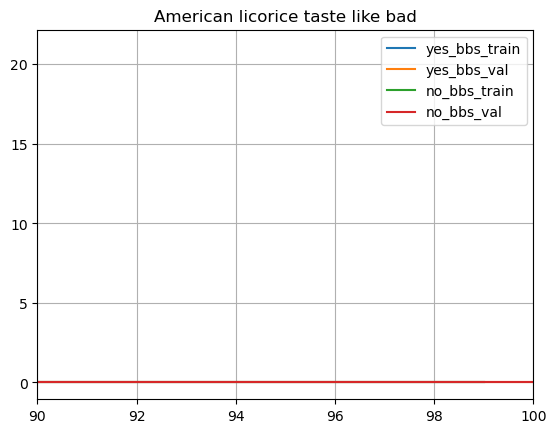

In [ ]:
plt.plot(loss_dict_m2['training_loss'], label = 'yes_bbs_train')
plt.plot(range(1, len(loss_dict_m2['val_loss'])+1), loss_dict_m2['val_loss'], label = 'yes_bbs_val')
plt.plot(loss_dict_m3['training_loss'], label = 'no_bbs_train')
plt.plot( range(1, len(loss_dict_m3['val_loss'])+1), loss_dict_m3['val_loss'], label = 'no_bbs_val')
plt.grid(True)
plt.legend()

plt.xlim([90 , 100])
plt.title('American licorice taste like great')
plt.show()

In [ ]:
min()

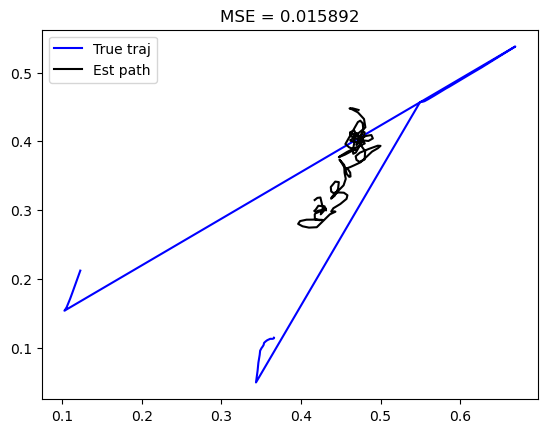

In [ ]:
plot_some_paths(model2.to(device=device), validation_dataloader, max_seq_time, criterion)

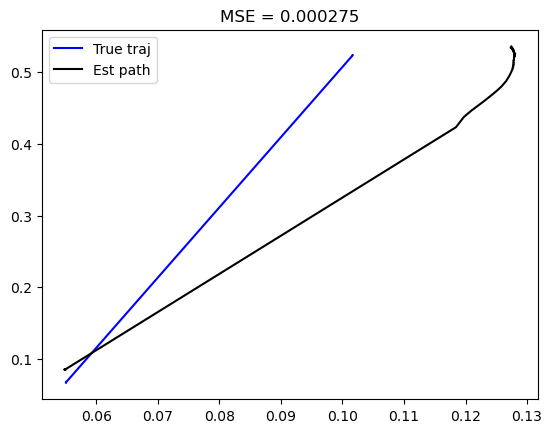

In [ ]:
plot_some_paths(model3.to(device=device), validation_dataloader, max_seq_time, criterion)